In [1]:
from os import path
from glob import glob
from tqdm import tqdm
import torch
import numpy as np

In [2]:
nomal_data = torch.load('waveoutvggish.pt')

In [3]:
nomal_data.shape

torch.Size([2871, 3, 128])

In [4]:
nomal_data = nomal_data.reshape((2871,-1))

In [5]:
nomal_data.shape

torch.Size([2871, 384])

In [6]:
broken_list = [1904, 2392, 2441, 2602] # 1118

In [7]:
# for idx in broken_list:
#     nomal_data[idx]._requires_grad=False

In [8]:
broken_aug_data = torch.load('broken-waveoutvggish.pt')

In [9]:
broken_aug_data.shape

torch.Size([2000, 3, 128])

In [10]:
broken_aug_data = broken_aug_data.reshape((2000, -1))

In [11]:
broken_aug_data.shape

torch.Size([2000, 384])

In [12]:
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

In [13]:
class SimpleClassifier(nn.Module):
    """
    Code from https://gist.github.com/santi-pdp/d0e9002afe74db04aa5bbff6d076e8fe
    """
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(384, 500)
        self.relu1 = nn.ReLU()
        self.dout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(500, 300)
        self.prelu = nn.PReLU(1)
        self.out = nn.Linear(300, 1)
        self.out_act = nn.Sigmoid()
        
    def forward(self, input_):
        a1 = self.fc1(input_)
        h1 = self.relu1(a1)
        dout = self.dout(h1)
        a2 = self.fc2(dout)
        h2 = self.prelu(a2)
        a3 = self.out(h2)
        y = self.out_act(a3)
        return y
    
model = SimpleClassifier()
opt = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999))
criterion = nn.BCELoss()

In [14]:
total_data = torch.cat((nomal_data, broken_aug_data), 0)
total_data.shape

torch.Size([4871, 384])

In [15]:
total_label = torch.cat((torch.ones(len(nomal_data), 1),torch.zeros(len(broken_aug_data), 1)), 0)
total_label.shape

torch.Size([4871, 1])

In [16]:
total_data.requires_grad_ = True

In [17]:
total_label

tensor([[1.],
        [1.],
        [1.],
        ...,
        [0.],
        [0.],
        [0.]])

In [18]:
def train_epoch(model, opt, criterion):
    model.train()
    opt.zero_grad()
    Variable(total_data, requires_grad=True)
    # (1) Forward
    y = model(total_data)
    # (2) Compute diff
    loss = criterion(y, total_label)
    # (3) Compute gradients
    loss.backward()
    # (4) update weights
    opt.step()
    return loss.data.numpy()

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

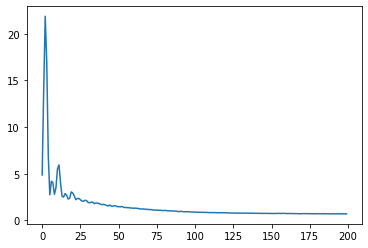

In [20]:
e_losses = []
num_epochs = 200
for e in range(num_epochs):
    e_losses.append(train_epoch(model, opt, criterion))
plt.plot(e_losses)

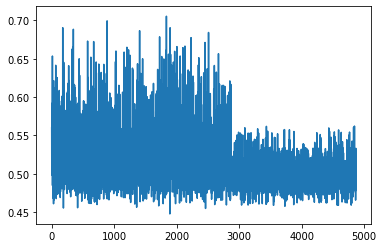

In [21]:
model.eval()
y = model(total_data).detach().numpy()
plt.plot(y)

In [22]:
for idx in broken_list:
    print(model(total_data[idx]))

tensor([0.5518], grad_fn=<SigmoidBackward>)
tensor([0.5398], grad_fn=<SigmoidBackward>)
tensor([0.4631], grad_fn=<SigmoidBackward>)
tensor([0.4801], grad_fn=<SigmoidBackward>)


In [23]:
np.mean(y[:2871])

0.5244992

In [24]:
np.min(y[:2871])

0.44757488

In [25]:
np.max(y[:2871])

0.7054173

In [26]:
np.mean(y[-2000:])

0.4977604

In [27]:
maxval = np.max(y[-2000:])
maxval

0.5621739

In [28]:
minval = np.min(y[-2000:])
minval

0.45756656

In [35]:
for idx, result in enumerate(y[:2871]):
    if  minval < result < maxval:
#         print(idx)
        pass

In [30]:
d = np.where(y > np.max(y[-2000:]))[0]

In [31]:
print(d)

[   7    9   12   23   26   28   31   34   44   46   58   65   70   76
   79   81   87  110  116  121  150  158  165  173  177  183  184  187
  190  193  201  205  206  214  218  221  236  246  248  256  264  265
  272  274  282  286  290  298  308  314  325  326  328  332  334  335
  337  341  346  347  351  354  364  366  375  383  391  413  424  428
  434  440  447  461  465  469  483  495  507  510  518  526  535  539
  545  546  554  555  575  576  579  581  582  588  590  598  602  613
  617  627  632  636  637  642  647  661  672  681  690  692  694  695
  704  712  715  722  740  750  754  755  789  792  793  795  798  801
  816  818  821  825  834  836  839  840  843  847  850  858  861  865
  870  880  882  887  904  905  920  927  929  931  942  947  949  952
  966  987  994  999 1010 1012 1021 1027 1029 1040 1047 1051 1052 1058
 1059 1066 1071 1072 1074 1076 1079 1080 1090 1095 1135 1141 1155 1159
 1173 1185 1189 1201 1204 1207 1208 1210 1217 1230 1239 1246 1253 1255
 1257 

In [33]:
d2 = np.where(y < np.min(y[-2000:]))[0]

In [34]:
print(d2)

[ 188  415 1360 1891 2462]
